In [1]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 60kB/s 
     |████████████████████████████████| 3.1MB 38.0MB/s 
     |████████████████████████████████| 501kB 43.0MB/s 


In [0]:
import os
import cv2
import PIL
import time
import glob
import pickle
import shutil
import imageio
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from IPython import display

# Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# PyDrive to save files to Drive

In [4]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 6.3MB/s 


# Helper functions and folder IDs

In [0]:
folder_ids = {
    'training_checkpoints' : '1MUnQgMnGMomNRXdsIuv0RcMBavyUm1l_'
}

def save_to_drive(folder_id, filename):
  file = drive.CreateFile({'title': filename.split('/')[-1],'parents':[{u'id': folder_id}]})
  file.SetContentFile(filename)
  file.Upload()
  
def save_folder_to_drive(folder_id, folder_name):
  filenames_in_folder = sorted(glob.glob(folder_name+"/*"))
  print(filenames_in_folder)
  for filename in filenames_in_folder:
    file = drive.CreateFile({'title': filename.split('/')[-1],'parents':[{u'id': folder_id}]})
    file.SetContentFile(filename)
    file.Upload()
    
def save_checkpoints(folder_id, prefix):
  filenames = sorted(glob.glob(prefix + '*'))
  print(filenames)
  for filename in filenames:
    file = drive.CreateFile({'title': filename.split('/')[-1],'parents':[{u'id': folder_id}]})
    file.SetContentFile(filename)
    file.Upload()
    
def load_data(root='/content/drive/My Drive/Thesis/keras-3dgan/data/coupeDataset/'):
  folders_path = sorted(glob.glob(os.path.join(root, '*/*/*')))
  dataset = []

  for folder in folders_path:
    frames_path = sorted(glob.glob(os.path.join(folder, '*.png')))
    frames_per_slice = []
    for frame in frames_path:
      frames_per_slice.append(cv2.resize(cv2.imread(frame), (128, 128)))
    numpy_frames = np.asarray(frames_per_slice)
    dataset.append(numpy_frames)

  return np.asarray(dataset)

def load_2d_data(root='/content/drive/My Drive/Thesis/keras-3dgan/data/coupeDataset/'):
  folders_path = sorted(glob.glob(os.path.join(root, '*/*/*')))
  dataset = []
  
  for folder in tqdm(folders_path):
    img_paths = sorted(glob.glob(os.path.join(folder, '*.png')))
    images = [cv2.resize(cv2.imread(img_path, 0)[60:188,55:183], (64, 64)) for img_path in img_paths[:20]]
    stacked_images = np.stack(images)
    dataset.append(stacked_images)
  dataset = np.array(dataset)
  return np.transpose(dataset, (0, 2, 3, 1))

def plot_volume(vol):
  plt.figure(figsize=(12, 10), dpi=80)
  for i in range(vol.shape[1]):
    img = tf.keras.backend.get_value(generated_image[0, i, :, :, :])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    
def plot_2d_volumes(vol):
  plt.figure(figsize=(30,6))
  for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(vol[:, :, i], cmap='gray')
    plt.axis('off')    
    
def pydrive():
  !pip install -U -q PyDrive

  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  # 1. Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

# Eager execution for better visualization and easy debugging

In [0]:
# tf.enable_eager_execution()

# Create Checkpoint directory and load pre-trained models from Drive

In [0]:
checkpoint_drive = '/content/drive/My Drive/Thesis/keras-3dgan/training_checkpoints/2D 64'
checkpoint_local = './training_checkpoints'

if not os.path.exists(checkpoint_local):
  os.mkdir(checkpoint_local)
else:
  shutil.rmtree(checkpoint_local, ignore_errors=True)
  os.mkdir(checkpoint_local)
  
checkpoints_in_drive = glob.glob(checkpoint_drive+'/ckpt*')

# Iterate over the last four paths in drive
for path in checkpoints_in_drive[-3:]:
  newPath = shutil.copy(path, checkpoint_local)
  
try: 
  newPath = shutil.copy(checkpoint_drive+'/checkpoint', checkpoint_local) 
except:
  pass

## Make checkpoint prefix for saving and restoring later

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Dataset

Load data via a Pickle or by processing the data in Google Drive (using the pickle is faster)

In [0]:
train_images = load_2d_data()

In [0]:
with open('/content/drive/My Drive/Thesis/keras-3dgan/pickles/dataset_2d_64.pickle', 'rb') as handle:
    train_images = pickle.load(handle)

In [14]:
# with open('/content/drive/My Drive/Thesis/keras-3dgan/pickles/dataset_2d.pickle', 'rb') as handle:
#     train_images = pickle.load(handle)

train_images = train_images.reshape(train_images.shape[0], 64, 64, 20).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

print("Dataset shape: {} with a min value of {} and a max value of {}".format(train_images.shape, train_images.min(), train_images.max()))

Dataset shape: (401, 64, 64, 20) with a min value of -1.0 and a max value of 0.9921568632125854


# Plotting volume in the dataset

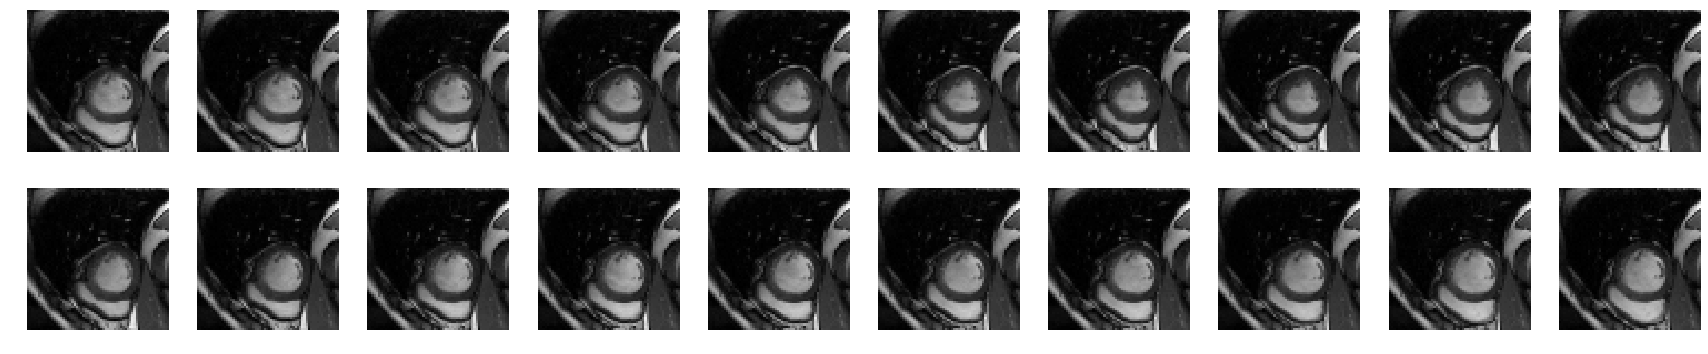

In [15]:
vol_n = 8

plot_2d_volumes(train_images[vol_n])

In [0]:
BATCH_SIZE = 32
BUFFER_SIZE = train_images.shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Define generator $G$

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(20, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 20)

    return model

# Define discriminator $D$

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 20]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Create both models

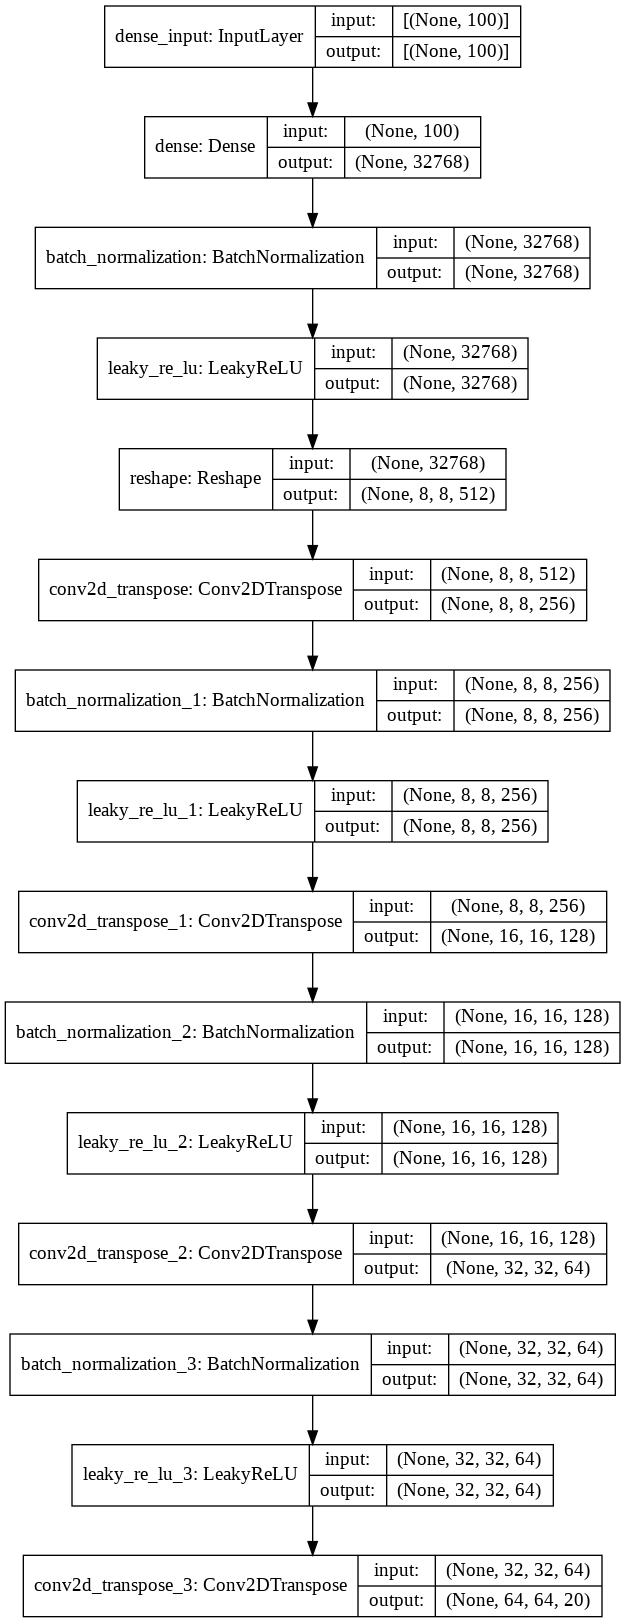

In [19]:
generator = make_generator_model()
keras.utils.plot_model(generator, 'generator.png', show_shapes=True)

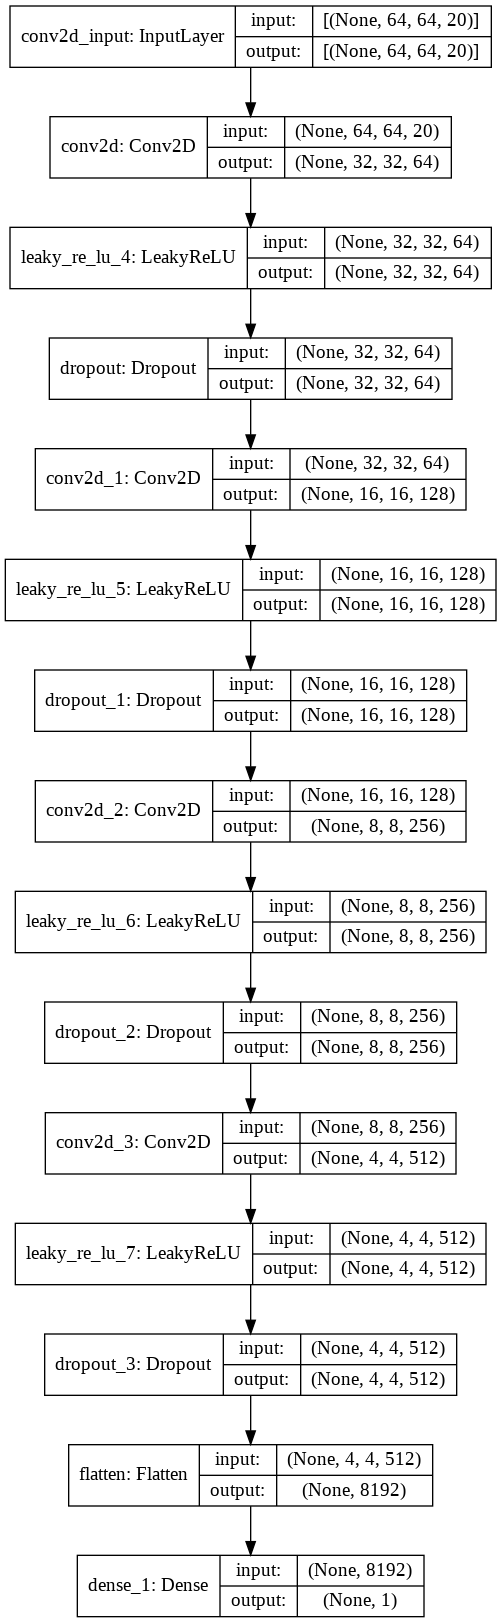

In [20]:
discriminator = make_discriminator_model()
keras.utils.plot_model(discriminator, 'discriminator.png', show_shapes=True)

# Define the loss and optimizers

In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Create Checkpoint

In [0]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Restore if there's any pre-trained model

In [36]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Take a look at the generated samples before training

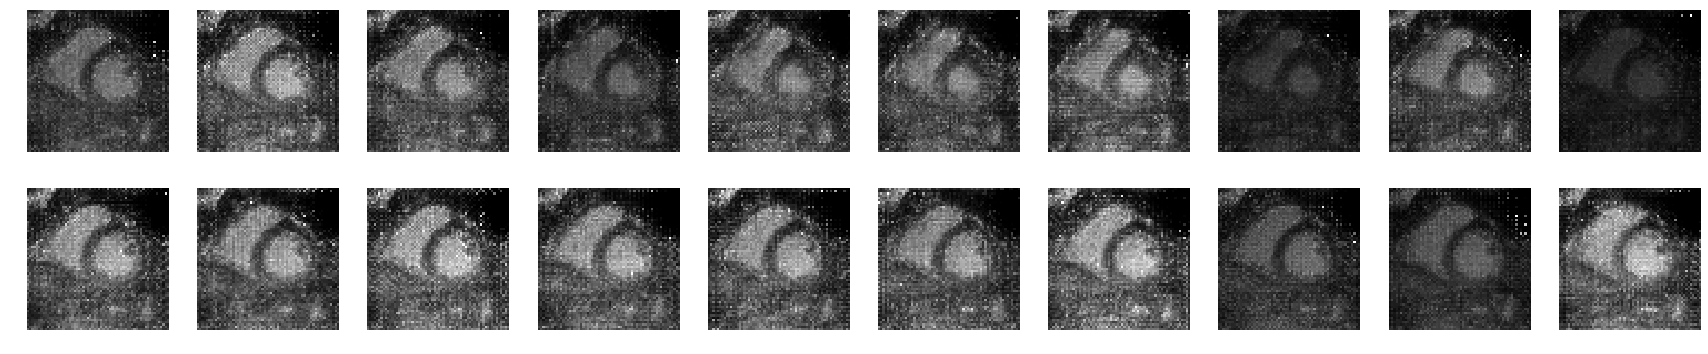

In [37]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

image = tf.keras.backend.get_value(generated_image)
plot_2d_volumes(image[0])

## Discriminator response

In [38]:
decision = discriminator(generated_image)

decision = tf.keras.backend.get_value(decision)
print (decision)

[[-2.6200385]]


# Define the training loop

In [0]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 1

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)noise
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Train

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 50 epochs
    if (epoch + 1) % 50 == 0:
      save_path = checkpoint.save(file_prefix = checkpoint_prefix)
      print("Saving last checkpoint to {}".format(save_path))
      try:
        save_checkpoints(folder_ids['training_checkpoints'], save_path)
      except:
        # If for some reason google colab throws invalid client secret exception
        pydrive()
        save_checkpoints(folder_ids['training_checkpoints'], save_path)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

# Generate and save images

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  plt.figure(figsize=(30,6))
  for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(predictions[0][:, :, i], cmap='gray')
    plt.axis('off')  
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

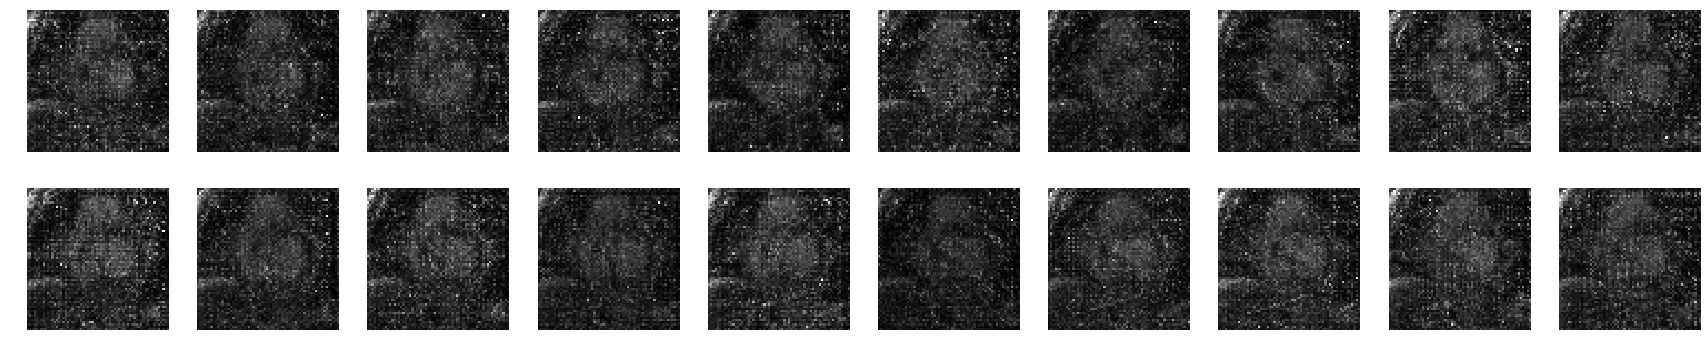

Time for epoch 386 is 4.164212465286255 sec


In [0]:
# %%time
train(train_dataset, 10000)

# Save folders to Drive

In [0]:
save_folder_to_drive(folder_ids['training_checkpoints'], 'training_checkpoints')

In [0]:
imgs_to_zip = sorted(glob.glob('image_*'))

from zipfile import ZipFile 

with ZipFile('progress.zip','w') as zip: 
  # writing each file one by one 
  for file in imgs_to_zip: 
    zip.write(file) 